In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
transform = transforms.ToTensor()

In [4]:
train_data = datasets.MNIST(root='../data',train=True, download=True, transform=transform)

In [5]:
test_data = datasets.MNIST(root='../data',train=False, download=True, transform=transform)

In [6]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train

In [7]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test

In [8]:
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

In [19]:
# 1 color channel, 6 filters(output channels), 3x3 kernel, stride 1
conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,stride=1)#입력값 채널 1, feature extraction 위한 out channel 6, 3x3 커널, 간격 1
# 6fillters -> pooling -> conv2

# 6 input filters conv1, 16 filters , 3x3 , stride=1
conv2 = nn.Conv2d(6,16,3,1)

# 6filters -> pooling --> conv2

In [32]:
for i,(X_train, y_train) in enumerate(train_data):
    break

In [33]:
x = X_train.view(1,1,28,28) # ---> 4D (batch of 1 image), num of image, height, width, color channels

In [34]:
x = F.relu(conv1(x))

In [35]:
x.shape

torch.Size([1, 6, 26, 26])

In [36]:
x = F.max_pool2d(x, 2,2) # kernel_size, stride

In [37]:
x.shape

torch.Size([1, 6, 13, 13])

In [38]:
x = F.relu(conv2(x))

In [39]:
x.shape

torch.Size([1, 16, 11, 11])

In [40]:
x = F.max_pool2d(x,2,2)

In [41]:
x.shape

torch.Size([1, 16, 5, 5])

In [45]:
x.view(-1,16*5*5).shape

torch.Size([1, 400])

In [47]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(5*5*16,120) # 120 flatten neurons
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X =  F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X,dim=1)

In [48]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [49]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [52]:
import time
start_time = time.time()

# variables (trackers)
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#for loop epochs
for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0
    
    for b,(X_train,y_train) in enumerate(train_loader):
        b+=1
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted==y_train).sum() # true 1 / false 0
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%600 ==0:
            print(f'epochs : {i} batch : {b} loss : {loss.item()}')
            
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    #test
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data,1)[1]
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)



current_time = time.time()
total = current_time - start_time
print(f'Training took {total/60} minutes')

epochs : 0 batch : 600 loss : 0.31027787923812866
epochs : 0 batch : 1200 loss : 0.41600924730300903
epochs : 0 batch : 1800 loss : 0.16521647572517395
epochs : 0 batch : 2400 loss : 0.008199945092201233
epochs : 0 batch : 3000 loss : 0.08922706544399261
epochs : 0 batch : 3600 loss : 0.010215569287538528
epochs : 0 batch : 4200 loss : 0.02709786221385002
epochs : 0 batch : 4800 loss : 0.015156214125454426
epochs : 0 batch : 5400 loss : 0.007667076773941517
epochs : 0 batch : 6000 loss : 0.01057092659175396
epochs : 1 batch : 600 loss : 0.02202516980469227
epochs : 1 batch : 1200 loss : 0.011518573388457298
epochs : 1 batch : 1800 loss : 0.006108864210546017
epochs : 1 batch : 2400 loss : 0.1721400022506714
epochs : 1 batch : 3000 loss : 0.0007635389920324087
epochs : 1 batch : 3600 loss : 0.00047114529297687113
epochs : 1 batch : 4200 loss : 0.0010694267693907022
epochs : 1 batch : 4800 loss : 0.013158644549548626
epochs : 1 batch : 5400 loss : 0.020098449662327766
epochs : 1 batch : 

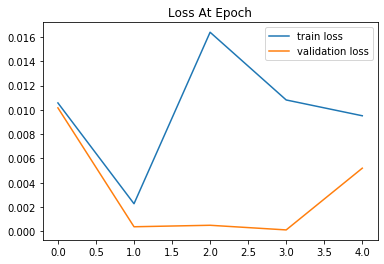

In [54]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss At Epoch')
plt.legend()

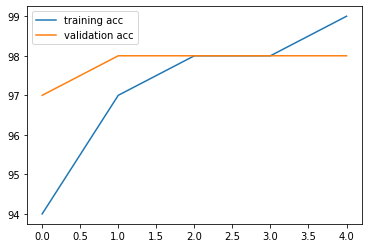

In [55]:
plt.plot([t/600 for t in train_correct], label='training acc')
plt.plot([t/100 for t in test_correct],label='validation acc')
plt.legend();

In [56]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [57]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val.data, 1)[1]
        correct += (predicted == y_test).sum()

In [59]:
correct.item()/len(test_data)

0.986

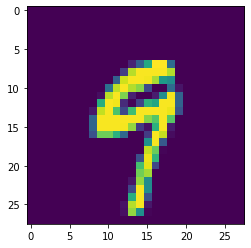

In [62]:
plt.imshow(test_data[2019][0].reshape(28,28))

In [63]:
model.eval()
with torch.no_grad():
    new_pred = model(test_data[2019][0].view(1,1,28,28))

In [65]:
new_pred.argmax()

tensor(9)

In [66]:
test_data[2019][1]

9